## Case Study - A/B-Testing for new homepage

Let's say that you're working for a fictional productivity software company that is looking for ways to increase the number of people who pay for their software. The way that the software is currently set up, users can download and use the software free of charge, for a 7-day trial. After the end of the trial, users are required to pay for a license to continue using the software.

One idea that the company wants to try is to change the layout of the homepage to emphasize more prominently and higher up on the page that there is a 7-day trial available for the company's software. The current fear is that some potential users are missing out on using the software because of a lack of awareness of the trial period. If more people download the software and use it in the trial period, the hope is that this entices more people to make a purchase after seeing what the software can do.

In this case study, you'll go through steps for planning out an experiment to test the new homepage. You will start by constructing a user funnel and deciding on metrics to track. You'll also perform experiment sizing to see how long it should be run. Afterwards, you'll be given some data collected for the experiment, perform statistical tests to analyze the results, and come to conclusions regarding how effective the new homepage changes were for bringing in more users.

### Building a funnel

#### Expected flow

A straightforward flow might include the following steps:

* Visit homepage
* Visit download page
* Sign up for an account
* Download software
* After 7-day trial, software takes user to license-purchase page
* Purchase license

Note that it is possible for the visitor to drop from the flow after each step, forming a funnel. There might be additional steps that a user might take between visiting the homepage and visiting the download page that aren't accounted for in the above flow. For example, someone might want to check out the additional informational pages before visiting the download page, or even visit the license purchase page to check the license price before even deciding to download. Considering the amount of browsing that a visitor could perform on the page, it might be simplest just to track whether or not a user gets to the download page at some point, without worrying about the many paths that they could have taken to get there.

### Deciding Metrics

There's one invariant metric that really stands out here, and that's the number of cookies that hit the homepage. If we've done things correctly, each visitor should have an equal chance of seeing each homepage, and that means that the number of cookies assigned to each group should be about the same. Since visitors come in without any additional information (e.g. account info) and the change effected by the experimental manipulation comes in right at the start, there aren't other invariant metrics we should worry about.

Selecting evaluation metrics is a trickier proposition. Count-based metrics at other parts of the process seem like natural choices: the number of times the software was downloaded and the number of licenses purchased are exactly what we want to change with the new homepage. The issue is that even though we expect the number of cookies assigned to each group to be about the same, it's much more likely than not they they won't be exactly the same. Instead, we should prefer using the download rate (# downloads / # cookies) and purchase rate (# licenses / # cookies) relative to the number of cookies as evaluation metrics. Using these ratios allows us to account for slight imbalances between groups.

### Experiment Sizing

##### Current Statistics

* 3250 visitors / day 
* 520 downloads / day (.16 rate)
* 65 licence buys / day (.02 rate)

##### Target

* increase of 50 downloads per day (up to 570 per day, or a .175 rate). How many days of data would we need to collect in order to get enough visitors to detect this new rate at an overall 5% Type I error rate and at 80% power?
* increase of 10 license purchases per day (up to 75 per day, or a .023 rate). How many days of data would we need to collect in order to get enough visitors to detect this new rate at an overall 5% Type I error rate and at 80% power?

##### Calculation Of Experiment Size

In [1]:
def experiment_size(p_null, p_alt, alpha = .05, beta = .20):
    """
    Compute the minimum number of samples needed to achieve a desired power
    level for a given effect size.
    
    Input parameters:
        p_null: base success rate under null hypothesis
        p_alt : desired success rate to be detected
        alpha : Type-I error rate
        beta  : Type-II error rate
    
    Output value:
        n : Number of samples required for each group to obtain desired power
    """
    
    # Get necessary z-scores and standard deviations (@ 1 obs per group)
    z_null = stats.norm.ppf(1-alpha)
    z_alt  = stats.norm.ppf(beta)
    sd_null = np.sqrt(p_null * (1-p_null) + p_null * (1-p_null))
    sd_alt  = np.sqrt(p_null * (1-p_null) + p_alt * (1-p_alt))
    
    # Compute and return minimum sample size
    p_diff = p_alt - p_null
    n = ((z_null*sd_null - z_alt*sd_alt) / p_diff) ** 2
    return np.ceil(n)

In [2]:
import scipy.stats as stats
import numpy as np

# Actual numbers
n_visits = 3250
n_downloads = 520
n_buys = 65

# Statistical parameters
alpha = .05
beta = .2

# Bonferoni correction
alpha_corrected = alpha/2

# Proportion for null hypothesis
p_null_downloads = n_downloads / n_visits
p_null_buys = n_buys / n_visits

# Proportion for alternative hypothesis
p_alt_downloads = (n_downloads+50) / n_visits
p_alt_buys = 75 / n_visits

In [3]:
n_downloads = experiment_size(p_null_downloads, p_alt_downloads, alpha=alpha_corrected, beta=beta)
print('Calculated minimal observations per group: {}'.format(n_downloads))
print('Minimal number of days: {}'.format(n_downloads * 2 /n_visits))

Calculated minimal observations per group: 9016.0
Minimal number of days: 5.548307692307692


In [4]:
n_buys = experiment_size(p_null_buys, p_alt_buys, alpha=alpha_corrected, beta=beta)
print('Calculated minimal observations per group: {}'.format(n_buys))
print('Minimal number of days: {}'.format(n_buys * 2 /n_visits))

Calculated minimal observations per group: 33223.0
Minimal number of days: 20.444923076923075


Because we have two evaluation metrics of interest, we should make sure that we are choosing an appropriate significance level to conduct each test, in order to preserve a maximum overall Type I error rate of .05. Since we would be happy to deploy the new homepage if either download rate or license purchase rate showed a statistically significant increase, performing both individual tests at a .05 error rate carries the risk of making too many Type I errors. As such, we'll apply the Bonferroni correction to run each test at a .025 error rate so as to protect against making too many errors. If it were the case that we needed to see both metrics with a statistically significant increase, then we wouldn't need to include the correction on the individual tests.

For an overall 5% Type I error rate with Bonferroni correction and 80% power, we should require 6 days (rounded up from 5.55) to reliably detect a 50 download increase per day and 21 days (rounded up from 20.44) to detect an increase of 10 license purchases per day. 21 days is actually a convenient number since the three-week timespan helps to account for weekly cycles. In addition, the 21-day data collection period is a short enough timeframe that running the experiment is a reasonable proposition. If the required experiment length were a few weeks longer, then we might have needed to forego measuring the license purchasing rate as a critical metric.

### Validity, Bias & Ethics

Before getting to the data and its analysis, let's review a few of the conceptual points that go into creation of an experiment: validity, bias, and ethics.

We probably don't have too much to worry about in terms of validity. For conceptual validity, the evaluation metrics are directly aligned with the experimental goals, no abstraction needed. Internal validity is maintained by performing an experiment with properly-handled randomization and controls. We don't really need to answer to external validity since we're drawing from the full site population and there's no other population we're looking to generalize to.

As for biases, we might think of novelty bias as being a potential issue. However, we don't expect users to come back to the homepage regularly. Downloading and license purchasing are actions we expect to only occur once per user, so there's no real 'return rate' to worry about. One possibility, however, is that if more people download the software under the new homepage, the expanded user base is qualitatively different from the people who came to the page under the original homepage. This might cause more homepage hits from people looking for the support pages on the site, causing the number of unique cookies under each condition to differ. If we do see something wrong or out of place in the invariant metric (number of cookies), then this might be an area to explore in further investigations.

Finally, for ethical issues, the changes to the homepage should be benign and present no risk to users. Our experiment objectives are also clearly stated. Considering the low risks of the experiment, informed consent is at worst a minor concern; a standard popup to let visitors know that cookies are used to track user experience on the site will likely suffice. The largest ethics principle we should be concerned about is data sensitivity. We shouldn't get any sensitive data out of the cookie assignment and collection, though some information will be collected from the user when they go to download the software. No sensitive data is required for the metrics we've laid out, so what we should do is just aggregate daily visits, downloads, and purchase counts without looking at any individual outcomes.

### Analyze Data

#### Explorary Data Analysis

In [5]:
import pandas as pd

data = pd.read_csv('data/homepage-experiment-data.csv')
data.head()

,Day,Control Cookies,Control Downloads,Control Licenses,Experiment Cookies,Experiment Downloads,Experiment Licenses
0,1,1764,246,1,1850,339,3
1,2,1541,234,2,1590,281,2
2,3,1457,240,1,1515,274,1
3,4,1587,224,1,1541,284,2
4,5,1606,253,2,1643,292,3


In [81]:
data.describe()

,Day,Control Cookies,Control Downloads,Control Licenses,Experiment Cookies,Experiment Downloads,Experiment Licenses
count,29.000000,29.000000,29.000000,29.000000,29.00000,29.000000,29.000000
mean,15.000000,1615.551724,260.482759,24.482759,1632.62069,294.758621,25.241379
std,8.514693,116.308268,28.338037,13.873461,113.02636,22.404807,13.762410
min,1.000000,1457.000000,223.000000,1.000000,1458.00000,256.000000,1.000000
25%,8.000000,1529.000000,240.000000,12.000000,1555.00000,279.000000,20.000000
50%,15.000000,1602.000000,254.000000,30.000000,1606.00000,290.000000,29.000000
75%,22.000000,1700.000000,276.000000,34.000000,1728.00000,300.000000,36.000000
max,29.000000,1822.000000,331.000000,42.000000,1861.00000,349.000000,44.000000


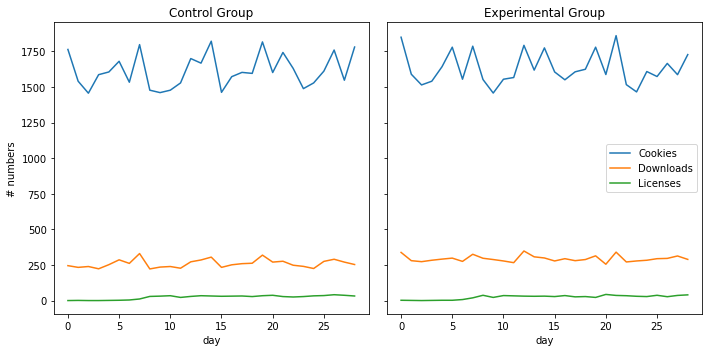

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(10, 5), sharey=True)
ax[0].plot(data['Control Cookies'])
ax[0].plot(data['Control Downloads'])
ax[0].plot(data['Control Licenses'])
ax[1].plot(data['Experiment Cookies'])
ax[1].plot(data['Experiment Downloads'])
ax[1].plot(data['Experiment Licenses'])
ax[0].set_xlabel('day')
ax[0].set_title('Control Group')
ax[0].set_ylabel('# numbers')
ax[1].set_xlabel('day')
ax[1].set_title('Experimental Group')
plt.legend(['Cookies', 'Downloads','Licenses'], loc='right')
plt.tight_layout()
plt.show()

In [38]:
data.iloc[:, 1:].mean()

Control Cookies         1615.551724
Control Downloads        260.482759
Control Licenses          24.482759
Experiment Cookies      1632.620690
Experiment Downloads     294.758621
Experiment Licenses       25.241379
dtype: float64

#### Invariant Metrics

First, we should check our invariant metric, the number of cookies assigned to each group. If there is a statistically significant difference detected, then we shouldn't move on to the evaluation metrics right away. We'd need to first dig deeper to see if there was an issue with the group-assignment procedure, or if there is something about the manipulation that affected the number of cookies observed, before we feel secure about analyzing and interpreting the evaluation metrics.

Q: What is the p-value for the test on the number of cookies assigned to each group?

*Analytical Approach*

In [113]:
p_null = .5
n_experiment = data['Experiment Cookies'].sum()
n_control = data['Control Cookies'].sum()
ratio_experiment = n_experiment / (n_experiment+n_control)
ratio_control = n_control / (n_experiment+n_control)
print('Experiment group # {}, ratio: {}'.format(n_experiment, ratio_experiment))
print('Control group # {}, ratio: {}'.format(n_control, ratio_control))

Experiment group # 47346, ratio: 0.5026274722124908
Control group # 46851, ratio: 0.4973725277875092


In [114]:
n_total = n_experiment + n_control
sd = np.sqrt(n_total * p_null * (1-p_null))
z_score = ((n_control + .5) - p_null * n_total) / sd
print('p-value: {}'.format(2 * stats.norm.cdf(z_score)))

p-value: 0.10749294050130412


*Simuation Approach*

In [118]:
n_experiment = data['Experiment Cookies'].sum()
n_control = data['Control Cookies'].sum()
n_total = n_experiment + n_control

In [150]:
# Simulate outcome under null hypothesis
p_null = .5
n_trials = 200_000

samples = np.random.binomial(n_total, p_null, n_trials)

p_value = np.logical_or(samples >= n_experiment, samples <= (n_total - n_experiment)).mean() 
print('p-value: {}'.format(p_value))

p-value: 0.107405


#### Evaluation Metrics

Assuming that the invariant metric passed inspection, we can move on to the evaluation metrics: download rate and license purchasing rate. For a refresher, the download rate is the total number of downloads divided by the number of cookies, and the license purchasing rate the number of licenses divided by the number of cookies.

One tricky point to consider is that there is a seven or eight day delay between when most people download the software and when they make a purchase. There's no direct way of attributing cookies all the way through license purchases due to the daily aggregation of results, so the best we can do is to make a justified argument for handling the data. To answer the question below about the license purchasing rate, you should only take the cookies observed through day 21 as the denominator of the ratio as being responsible for all of the license purchases observed. (A more informed model of license purchasing could come up with a different handling of the data, such as including part of the day 22 cookies in the denominator.) (Note that we don't need to perform this kind of correction for the download rate, since the link between homepage visits and downloads is much closer.)

Q: What is the p-value for the test on the download rate between groups?

*Basics*

In [236]:
n_experiment = data['Experiment Cookies'].sum()
n_control = data['Control Cookies'].sum()
n_total = n_experiment + n_control

In [237]:
p_null_downloads = ((data['Experiment Downloads'] + data['Control Downloads']) / \
    (data['Experiment Cookies'] + data['Control Cookies'])).mean()
print('Overall download rate: {:.5} (download/cookie)'.format(p_null_downloads))

Overall download rate: 0.17097 (download/cookie)


In [238]:
p_experiment = (data['Experiment Downloads'] / data['Experiment Cookies']).mean()
p_control = (data['Control Downloads'] / data['Control Cookies']).mean()
p_diff = p_experiment - p_control
print('Experiment download rate: {:>12.5} (download/cookie)'.format(p_experiment))
print('Control download rate: {:>15.5} (download/cookie)'.format(p_control))
print('Differences in proportion: {:>12.5} (download/cookie)'.format(p_diff))

Experiment download rate:      0.18069 (download/cookie)
Control download rate:         0.16111 (download/cookie)
Differences in proportion:     0.019585 (download/cookie)


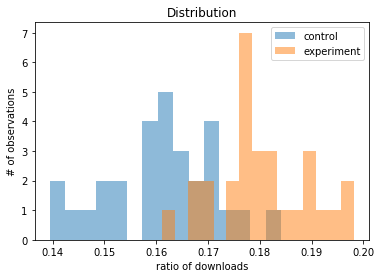

In [229]:
plt.hist(data['Control Downloads'] / data['Control Cookies'], bins=15, alpha=.5)
plt.hist(data['Experiment Downloads'] / data['Experiment Cookies'], bins=15, alpha=.5)
plt.title('Distribution')
plt.ylabel('# of observations')
plt.xlabel('ratio of downloads')
plt.legend(['control','experiment'])
plt.show()

*Analytical Approach*

In [239]:
sd = np.sqrt(n_total * p_null_downloads * (1-p_null_downloads))
z_score = ((n_control + .5) - p_null_downloads * n_total) / sd
print('p-value: {}'.format(1-stats.norm.cdf(z_score)))

p-value: 0.0


In [247]:
# Calculate standard error
se_p = np.sqrt(p_null_downloads * (1-p_null_downloads) * (1/n_control + 1/n_experiment))

# Z score
z_score = p_diff / se_p
print('z-score: {}'.format(z_score))
print('p-value: {}'.format(1-stats.norm.cdf(z_score)))

z-score: 7.982903713862084
p-value: 6.661338147750939e-16


*Simulation Approach*

In [232]:
n_trials = 200_000

# Draw sample same size as experiment group
samples = np.random.binomial(n_experiment, p_null_downloads, n_trials)

In [233]:
# How often are there more samples than
p_value = np.logical_or(samples >= data['Experiment Downloads'].sum(), 
                        samples <= data['Control Downloads'].sum()).mean()
print('p-value: {}'.format(p_value))

p-value: 0.0


Q: What is the p-value for the test on the license purchasing rate between groups?

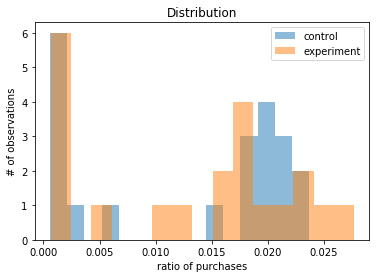

In [275]:
plt.hist(data.loc[:20, 'Control Licenses'] / data.loc[:20, 'Control Cookies'], bins=15, alpha=.5)
plt.hist(data.loc[:20, 'Experiment Licenses'] / data.loc[:20, 'Experiment Cookies'], bins=15, alpha=.5)
plt.title('Distribution')
plt.ylabel('# of observations')
plt.xlabel('ratio of purchases')
plt.legend(['control','experiment'])
plt.show()

*Analytical Approach*

In [266]:
data_cookies = data.loc[:20, :]

p_experiment = data['Experiment Licenses'].sum() / data_cookies['Experiment Cookies'].sum()
p_control = data['Control Licenses'].sum() / data_cookies['Control Cookies'].sum()
p_null = (data['Experiment Licenses'].sum() + data['Control Licenses'].sum()) / \
        (data_cookies['Experiment Cookies'].sum() + data_cookies['Control Cookies'].sum())
p_diff = p_experiment - p_control
print('p-experiment: {:.4}'.format(p_experiment))
print('p-control: {:.4}'.format(p_control))
print('p-null: {:.4}'.format(p_null))
print('Differences in proportion: {:.4}'.format(p_diff))

p-experiment: 0.02132
p-control: 0.02103
p-null: 0.02118
Differences in proportion: 0.0002854


In [269]:
n_control = data_cookies['Control Cookies'].sum()
n_experiment = data_cookies['Experiment Cookies'].sum()

In [276]:
# Calculate standard error
se_p = np.sqrt(p_null * (1-p_null) * (1/n_control+ 1/n_experiment))

# Z score
z_score = p_diff / se_p
print('z-score: {}'.format(z_score))
print('p-value: {}'.format(1-stats.norm.cdf(z_score)))

z-score: 0.2586750111658684
p-value: 0.3979430008399871


*Analytical Approach*